<a href="https://colab.research.google.com/github/aderdouri/PINNs/blob/master/Tutorials/Inverse_BlackScholes_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Black-Scholes Partial Differential Equation (PDE)
The value of an option $V(S, t)$ satisfies the Black-Scholes PDE:
$$
\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + r S \frac{\partial V}{\partial S} - r V = 0
$$

### Initial and Boundary Conditions of the Black-Scholes PDE

The initial and boundary conditions for the Black-Scholes PDE depend on the type of derivative being priced, such as European call or put options. These conditions are necessary for solving the PDE and obtaining specific option prices. We will consider a Call option.

- $\textbf{Initial Condition}$ (at $t = T$):
    - $\text{Call: } V(S, T) = \max(S - K, 0)$ \\
- $\textbf{Boundary Conditions:}$
  - $V(0, t) = 0$ \\
  - $V(S, t) \to S - K e^{-r(T-t)} \quad \text{as } S \to \infty$

These conditions, combined with the Black-Scholes PDE, provide a complete specification for determining the price of the option.


## Implementation

In [18]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

## Analytic formula

In [6]:
def bs_pde_residual(model, S, t):
    """
    Compute the PDE residual for the Black-Scholes equation:
    dV/dt + 0.5 * sigma^2 * S^2 * d^2V/dS^2 + r * S * dV/dS - r * V = 0

    Args:
        model (torch.nn.Module): The PINN model that predicts V(S, t).
        S (torch.Tensor): Asset price tensor (requires_grad=True).
        t (torch.Tensor): Time tensor (requires_grad=True).

    Returns:
        torch.Tensor: The residual of the Black-Scholes PDE.
    """
    # Ensure gradients can be computed for S and t
    S.requires_grad = True
    t.requires_grad = True

    # Model prediction for V(S, t)
    V = model(S, t)

    # First-order derivative w.r.t. S
    V_S = torch.autograd.grad( V, S, grad_outputs=torch.ones_like(V), create_graph=True)[0]

    # First-order derivative w.r.t. t
    V_t = torch.autograd.grad(V, t, grad_outputs=torch.ones_like(V), create_graph=True)[0]

    # Second-order derivative w.r.t. S
    V_SS = torch.autograd.grad(V_S, S, grad_outputs=torch.ones_like(V_S), create_graph=True)[0]

    # PDE residual
    residual = V_t + 0.5 * (model.sigma)**2 * S**2 * V_SS + model.r * S * V_S - model.r * V

    # Debugging prints (optional, for tracking intermediate values)
    #if torch.isnan(residual).any():
    #    print("NaN detected in residual!")
    #print(f"V_t: {V_t.mean().item()}, V_S: {V_S.mean().item()}, V_SS: {V_SS.mean().item()}, Residual: {residual.mean().item()}")

    return residual

# Step 2: Define the PINN model
import torch
import torch.nn as nn

class PINN(nn.Module):
    """Physics-Informed Neural Network for Black-Scholes equation."""
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = nn.Sequential(
            nn.Linear(2, 50),  # Inputs: (S, t)
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)  # Output: V(S, t)
        )

        # Define r and sigma as trainable parameters
        self.r = nn.Parameter(torch.tensor(0.05, dtype=torch.float32, requires_grad=True))
        self.sigma = nn.Parameter(torch.tensor(0.30, dtype=torch.float32, requires_grad=True))

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        for layer in self.hidden_layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)

    def forward(self, S, t):
        input_tensor = torch.cat((S, t), dim=1)  # Combine S and t
        return self.hidden_layers(input_tensor)

    def print_params(self):
        print(f"r: {self.r.item():.6f}, sigma: {self.sigma.item():.6f}")


# Step 3: Define the loss function
def compute_loss(model, S_interior, t_interior,
                 S_boundary, t_boundary, V_boundary,
                 S_initial, t_initial, V_initial, epoch=0):
    """Compute the combined loss for the PDE residual, boundary, and initial conditions."""

    # PDE residual loss
    residual = bs_pde_residual(model, S_interior, t_interior)
    pde_loss = torch.mean(residual**2)

    # Boundary condition loss:
    # V(0, t)=0
    # V(S, t)→S-K*exp(−r(T−t))as 𝑆→∞

    # Pass S_boundary[0] and t_boundary as separate arguments
    V_boundary_low_pred = model(S_boundary[0], t_boundary)
    # Pass S_boundary[1] and t_boundary as separate arguments
    V_boundary_high_pred = model(S_boundary[1], t_boundary)
    bc_loss = torch.mean((V_boundary_low_pred - V_boundary[0])**2) + \
              torch.mean((V_boundary_high_pred - V_boundary[1])**2)


    # Initial condition loss:
    # (at 𝑡=𝑇): 𝑉(𝑆,𝑇)=max(𝑆−𝐾,0)
    V_initial_pred = model(S_initial, t_initial)  # Pass S_initial and t_initial as separate arguments
    ic_loss = torch.mean((V_initial_pred - V_initial)**2)

    if epoch % 100 == 0:
      print(f"Adam Epoch {epoch}, PDE Loss: {pde_loss.item()}, BC Loss: {bc_loss.item()}, IC Loss: {ic_loss.item()}")

    return pde_loss + bc_loss + ic_loss

# Step 4: Training the model
def train_pinn(model, S_interior, t_interior,
               S_boundary, t_boundary, V_boundary,
               S_initial, t_initial, V_initial, adam_epochs=1000, lbfgs_epochs=500):
    """Train the PINN model using Adam and LBFGS optimizers."""
    # Adam optimizer for initial training
    optimizer_adam = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(adam_epochs):
        optimizer_adam.zero_grad()
        loss = compute_loss(model, S_interior, t_interior,
                            S_boundary, t_boundary, V_boundary,
                            S_initial, t_initial, V_initial, epoch)
        loss.backward()
        optimizer_adam.step()
        if epoch % 100 == 0:
          print(f"Epoch {epoch}, Sigma Gradient: {model.sigma.grad}, r Gradient: {model.r.grad}")
          print(f"Epoch {epoch}, Loss: {loss.item():.6f}, r: {model.r.item():.6f}, sigma: {model.sigma.item():.6f}")


    for name, param in model.named_parameters():
        if param.requires_grad:
            print('param.requires_grad:', name)


    # LBFGS optimizer for fine-tuning
    optimizer_lbfgs = torch.optim.LBFGS(model.parameters(), max_iter=lbfgs_epochs,
                                        tolerance_grad=1e-7, tolerance_change=1e-9)

    lbfgs_iter = 0
    def closure():
        nonlocal lbfgs_iter
        optimizer_lbfgs.zero_grad()
        loss = compute_loss(model, S_interior, t_interior,
                            S_boundary, t_boundary, V_boundary,
                            S_initial, t_initial, V_initial, 1)
        loss.backward()
        if lbfgs_iter % 100 == 0:
            print(f"LBFGS Iteration {lbfgs_iter}, Loss: {loss.item():.6f}, r: {model.r.item():.6f}, sigma: {model.sigma.item():.6f}")

        lbfgs_iter += 1

        return loss

    print("Starting LBFGS optimization...")
    optimizer_lbfgs.step(closure)

In [7]:
# Underlying asset and time are normalized BUT not option values.
# This setup ensures the inputs are normalized for stable training,
# while the target outputs remain unnormalized to preserve
# the real-world scale of the option values.

S_max = 150.0
S_min = 50.0
K = 100.0
T = 5.0
r = 0.05

S = torch.linspace(S_min, S_max, 100).view(-1, 1)
# Normalize S
S_norm = (S - S_min) / (S_max - S_min)
t = torch.linspace(0, T, 100).view(-1, 1)
t_norm = (t - 0) / (T - 0)

# Create mesh grid for interior points
S_grid, t_grid = torch.meshgrid(S_norm.squeeze(), S_norm.squeeze(), indexing='ij')
S_interior = S_grid.flatten().view(-1, 1)
t_interior = t_grid.flatten().view(-1, 1)

# Boundary points
# V(0, t)=0
# V(S, t)→S-K*exp(−r(T−t))as 𝑆→∞
t_boundary = S_norm
S_boundary = [torch.full_like(t, 0), torch.full_like(t, 1.0)] # due to normalization
V_boundary = [torch.full_like(t, 0), S_max - K * torch.exp(-r * (T - t))]


# Initial points
# (at 𝑡=𝑇): 𝑉(𝑆, 𝑇)=max(𝑆−𝐾, 0)
S_initial = S_norm
t_initial = torch.full_like(t, 1.0) # due to normalization
V_initial = torch.maximum(S - K, torch.tensor(0.0))

In [ ]:
# Step 6: Initialize and train the PINN
model = PINN()
train_pinn(model, S_interior, t_interior, S_boundary, t_boundary, V_boundary,
           S_initial, t_initial, V_initial,
           adam_epochs=20000, lbfgs_epochs=50000)

In [15]:
#torch.set_printoptions(sci_mode=False)
np.set_printoptions(suppress=True, precision=6)

# Step 7: Visualize the results
# Create a grid for prediction
S_pred = torch.linspace(S_min, S_max, 100).view(-1, 1)
S_pred_norm = (S_pred - S_min) / (S_max - S_min)

t_pred = torch.linspace(0, T, 100).view(-1, 1)
t_pred_norm = (t_pred - 0) / (T - 0)
S_grid_pred, t_grid_pred = torch.meshgrid(S_pred_norm.squeeze(), t_pred_norm.squeeze(),
                                          indexing='ij')
S_flat = S_grid_pred.flatten().view(-1, 1)
t_flat = t_grid_pred.flatten().view(-1, 1)

# Make predictions using the trained model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation for inference
    V_pred = model(S_flat, t_flat).detach().numpy()

V_pred = V_pred.reshape(100, 100)
print(V_pred)


# black_scholes(S, t, T, K, r, sigma)
sigma = 0.20
S_grid_pred, t_grid_pred = torch.meshgrid(S_pred.squeeze(), t_pred.squeeze(),
                                          indexing='ij')
S_flat = S_grid_pred.flatten().view(-1, 1)
t_flat = t_grid_pred.flatten().view(-1, 1)
V_exact = black_scholes(S_flat, t_flat, T, K, r, sigma)
V_exact = V_exact.reshape(100, 100)
print(V_exact.detach().numpy())

[[-0.000895 -0.000567 -0.00036  ...  0.000218  0.000259  0.000303]
 [ 0.002091  0.002326  0.002461 ...  0.001423  0.00145   0.001479]
 [ 0.004343  0.004505  0.004583 ...  0.002383  0.002397  0.002412]
 ...
 [68.64011  68.44176  68.24349  ... 48.097767 48.00382  47.911617]
 [70.38399  70.18831  69.99105  ... 49.149155 49.02725  48.913776]
 [72.109924 71.92253  71.728645 ... 50.49619  50.295055 50.112194]]
[[ 2.328528  2.273104  2.218119 ...  0.        0.        0.      ]
 [ 2.559029  2.500034  2.441475 ...  0.        0.        0.      ]
 [ 2.803271  2.740661  2.678473 ...  0.        0.        0.      ]
 ...
 [71.698784 71.49028  71.28107  ... 48.483574 48.232002 47.979797]
 [72.66059  72.45214  72.24301  ... 49.493675 49.242104 48.9899  ]
 [73.62392  73.41553  73.20644  ... 50.503777 50.252205 50.      ]]


<ipython-input-2-57165c588757>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tau = torch.tensor(tau, dtype=torch.float32)


In [16]:
V_pred.shape, V_pred[:, 99]

((100, 100),
 array([ 0.000303,  0.001479,  0.002412,  0.003126,  0.003638,  0.003968,
         0.004137,  0.004159,  0.00405 ,  0.003828,  0.003504,  0.003093,
         0.002608,  0.002061,  0.001468,  0.000836,  0.000183, -0.000482,
        -0.001143, -0.001788, -0.002403, -0.002975, -0.003486, -0.003923,
        -0.004267, -0.004503, -0.004612, -0.004578, -0.00438 , -0.004001,
        -0.003426, -0.002633, -0.001606, -0.000338,  0.001177,  0.002931,
         0.004897,  0.007014,  0.00917 ,  0.011179,  0.012734,  0.013364,
         0.012368,  0.008762,  0.001309, -0.011172, -0.028568, -0.045347,
        -0.037354,  0.077492,  0.5128  ,  1.467289,  2.565182,  3.5376  ,
         4.532093,  5.550741,  6.564536,  7.577584,  8.591747,  9.603302,
        10.610584, 11.615445, 12.620974, 13.629299, 14.640743, 15.654177,
        16.667908, 17.680536, 18.691442, 19.70077 , 20.709108, 21.717169,
        22.725498, 23.734419, 24.744074, 25.754492, 26.765627, 27.77733 ,
        28.789303, 29.801

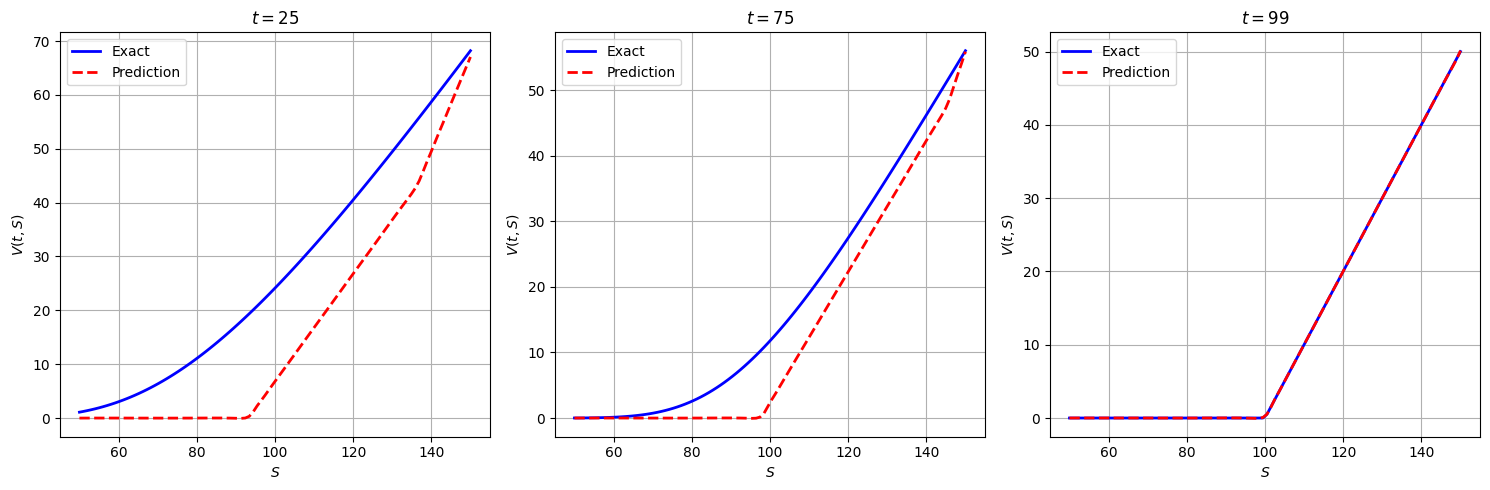

In [17]:
# Step 8: Compare predictions with exact solution at specific time slices
time_slices = [25, 75, 99]  # Time slices to compare

plt.figure(figsize=(15, 5))

for i, t_slice in enumerate(time_slices):
    # Extract points for the time slice
    t_slice_tensor = torch.full_like(S_pred, t_slice)
    V_pred_slice = V_pred[:, t_slice]

    # Compute exact solution
    V_exact_slice = V_exact[:,t_slice]

    # Plot comparison
    plt.subplot(1, 3, i + 1)
    plt.plot(S_pred.numpy(), V_exact_slice, 'b-', label='Exact', linewidth=2)
    plt.plot(S_pred.numpy(), V_pred_slice, 'r--', label='Prediction', linewidth=2)
    plt.title(f"$t = {t_slice}$")
    plt.xlabel("$S$")
    plt.ylabel("$V(t, S)$")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()
